In [1]:
!pip install cptac
!pip install --upgrade cptac

Requirement already up-to-date: cptac in c:\users\chels\anaconda3\lib\site-packages (0.8.0)


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import cptac
import pyensembl
from scipy import stats

In [34]:
cptac.download(dataset="ovarian")
ovarian = cptac.Ovarian()

In [35]:
ensembl = pyensembl.EnsemblRelease()

In [36]:
ovarian_cnv = ovarian.get_CNV()

In [37]:
def separate(hiCut, lowCut, data):
  """
  Counts the Number of patients with high and low value for each gene.
  """
  sepDict = dict()
  for column in data:
    numHi = 0
    numLow = 0
    numNeu = 0
    for i in data[column]:
        if i > hiCut:
            numHi += 1
        elif i < lowCut:
            numLow += 1
        else:
            numNeu += 1 
    sepDict[column] = [numHi, numNeu, numLow]
  return sepDict

In [38]:
def get_counts_and_average(data):
  """
  Takes a CNV dataframe and generates a dataframe with the counts of high, low and neutral values
  """
  df = pd.DataFrame(data = separate(.3,-.2,data), index = ["amplifications", "neutral", "deletions"])
  df = df.append(pd.DataFrame(data.mean(0), columns=['average']).transpose(), sort=True)
  return df.transpose()

In [39]:
ovarian_counts = get_counts_and_average(ovarian_cnv)

In [40]:
def add_chromo_and_loc(my_dict, cancer):
    chromo = list()
    locations = list()
    not_found = list()
    count = 0
    for gene in list(my_dict.index.get_level_values(0)):
        count += 1
        try:
            e_gene = ensembl.genes_by_name(gene)
            chromo.append(e_gene[0].contig)
            locations.append((e_gene[0].start + e_gene[0].end)/2)
        except:
            not_found.append(gene)
            chromo.append(None)
            locations.append(None)
    my_dict['chromo'] = chromo
    my_dict['location'] = locations
    my_dict['cancer'] = cancer
    print(len(not_found)/count)
    return my_dict

In [41]:
ovarian_counts = add_chromo_and_loc(ovarian_counts, "OVARIAN")

0.05881324318022849


In [42]:
chromosome_num = '8'

In [43]:
ovarian_counts_cleaned = ovarian_counts.dropna(subset=['location'])
ovarian_counts_cleaned_8 = ovarian_counts_cleaned[ovarian_counts_cleaned.chromo=='8']

In [44]:
genes_before_intersect = ovarian_counts_cleaned_8[ovarian_counts_cleaned_8.deletions > 60]

In [45]:
ovarian_counts_8 = ovarian_counts[ovarian_counts.chromo == chromosome_num]
ovarian_counts_8 = pd.melt(ovarian_counts_8, id_vars=['chromo', 'location', 'cancer'], value_vars=['amplifications', 'deletions'])

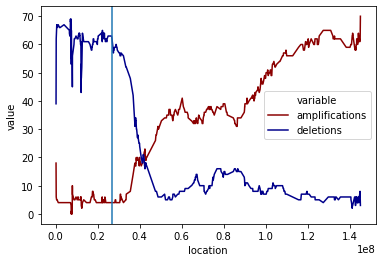

In [46]:
sns.lineplot(x="location", y="value", hue="variable", palette=['darkred', 'darkblue'], data=ovarian_counts_8)
plt.axvline(max(genes_before_intersect.location))

In [74]:
max(genes_before_intersect.location)

26807714.0

In [63]:
gene_list = list(ovarian_counts_cleaned_8[ovarian_counts_cleaned_8.location < max(genes_before_intersect.location)].index)

In [64]:
df_before_intersect = ovarian_cnv[gene_list]

In [65]:
def calc_percent(row):
    values = list(row)
    return(len([x for x in values if x <= -0.2]) / len(values))

In [66]:
df_before_intersect['percent'] = df_before_intersect.apply(calc_percent, axis=1)

C:\Users\chels\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [67]:
have_event = list(df_before_intersect[df_before_intersect.percent >.8].index)
no_event = [x for x in df_before_intersect.index if x not in have_event]

In [68]:
print(len(have_event))
print(len(no_event))

53
47


In [69]:
ovarian_prot = ovarian.get_proteomics()

In [70]:
def t_test(col):
    has_ev = col[col.index.isin(have_event)]
    no_ev = col[col.index.isin(no_event)]
    return stats.ttest_ind(has_ev, no_ev)

In [71]:
ovarian_t_test = ovarian_prot.apply(t_test).transpose()
ovarian_t_test = ovarian_t_test.rename(columns={0:"statistic", 1:"p-value"})

C:\Users\chels\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\chels\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\chels\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


In [75]:
ovarian_t_test

,,statistic,p-value
Name,Database_ID,,
A1BG,NP_570602,-2.439077,0.016967
A2M,NP_000005,-2.184034,0.031926
A2ML1,NP_653271,NaN,NaN
AAAS,NP_056480,0.599025,0.550870
AACS,NP_076417,1.110835,0.270009
...,...,...,...
ZWINT,NP_008988,NaN,NaN
ZYG11B,NP_078922,2.365464,0.020460
ZYX,NP_001010972,0.205393,0.837793
